# Модели классификации и порядковой регрессии

При описании целевой переменной, необходимо также учитывать «природу» данных. Возможно, рассматриваемые значения целевых переменных изначально имели порядок относительно друг друга. Тогда вместо модели многоклассовой классификации стоит рассмотреть модель порядковой регрессии, или обучить несколько моделей бинарной классификации.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Бинарная классификация

Рассмотрим задачу кредитного скоринга. Здесь целевая переменная SeriousDlqin2yrs &ndash; факт того, что данный клиент просрочил выплаты по кредиту. Данные содержат пропуски, которые мы заполним медианой.

In [2]:
data = pd.read_csv('data/credit_scoring_sample.csv', sep=';')

In [3]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


In [5]:
cols_to_fill = ['MonthlyIncome', 'NumberOfDependents']
data[cols_to_fill] = data[cols_to_fill].fillna(data[cols_to_fill].median(axis=0))

Важно отметить, что выборка несбалансированная, что также необходимо учитывать при построении моделей.

In [6]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']

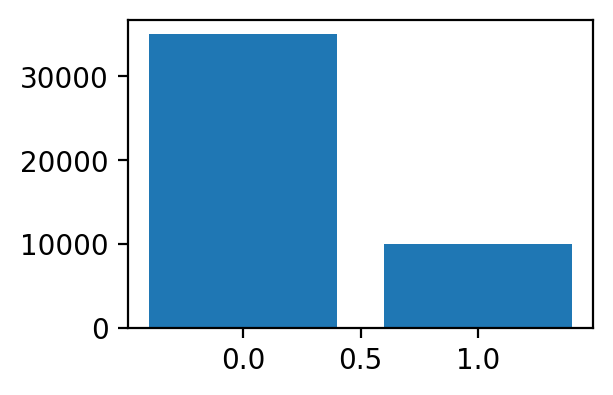

In [7]:
y_counts = y.value_counts()

plt.figure(figsize=(3, 2), dpi=200)
plt.bar(y_counts.index, y_counts.values)
plt.show()

Разобьем выборку на обучающую и контрольную (`sklearn.model_selection.train_test_split`), после чего обучим модель логистической регрессии в statsmodels (`statsmodels.genmod.generalized_linear_model.GLM(family=Binomial())`) и sklearn (`sklearn.linear_model.LogisticRegression`). Методы обучения линейных моделей чувствительны к масштабу признаков. Чтобы привести значения признаков к единому масштабу, воспользуемся методом стандартизации данных (`sklearn.preprocessing.StandardScaler`):

$$\hat{x}_{ij} = \dfrac{x_{ij} - \overline{x}_j}{\sigma_j}$$

In [8]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

from sklearn.preprocessing import StandardScaler

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Метод `fit` в данном случае вычислит и запомнит выборочное среднее и выборочное отклонение по каждому из признаков обучающей выборки. Метод `transform` &ndash; преобразует значения признаков каждого из объектов выборки.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
model_sm = GLM(
    y_train, 
    X_train_scaled, 
    family=families.Binomial()
).fit()

model_sl = LogisticRegression(
    random_state=42, solver='liblinear' # liblinear рекомендуется вместо значения по умолчанию
)
model_sl.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [12]:
pred_sm = model_sm.predict(X_test_scaled)
pred_sl = model_sl.predict(X_test_scaled)

Результаты модели из statsmodels из вероятностей переведем в значения класса. Качество оценим с помощью матрицы ошибок, доли правильных ответов, точности, полносты и F-меры. Также рассчитаем метрику F-beta, которая большее предпочтение будет отдавать более редкому классу.

In [13]:
pred_sm = np.where(pred_sm > 0.5, 1, 0)

In [14]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score
)

In [15]:
for model_name, elem in zip(['statsmodels', 'sklearn'], [pred_sm, pred_sl]):
    print('\n', model_name)
    print('accuracy:', accuracy_score(y_test, elem))
    print('precision:', precision_score(y_test, elem))
    print('recall:', recall_score(y_test, elem))
    print('f1_score:', f1_score(y_test, elem))
    print('f2_score:', fbeta_score(y_test, elem, beta=2))


 statsmodels
accuracy: 0.8353843050231995
precision: 0.7139479905437353
recall: 0.45034297643900983
f1_score: 0.5523043160204828
f2_score: 0.4862497584852193

 sklearn
accuracy: 0.7968529352430905
precision: 0.7651757188498403
recall: 0.14285714285714285
f1_score: 0.24076401105805478
f2_score: 0.17060834876763073


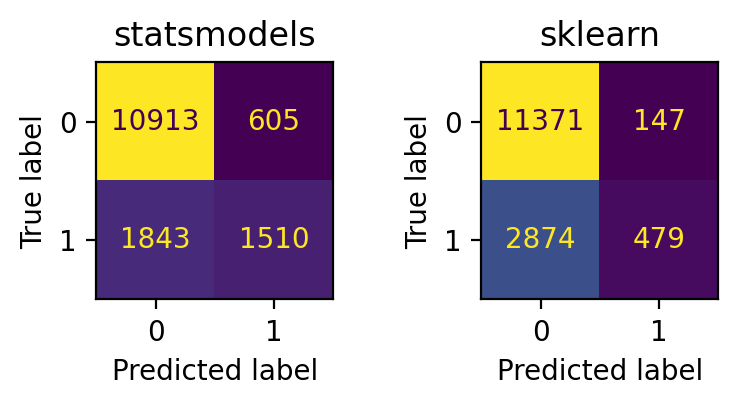

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), dpi=200)
cm_sm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_sm))
cm_sl = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_sl))
cm_sm.plot(ax=ax[0], colorbar=False)
ax[0].set_title('statsmodels')
cm_sl.plot(ax=ax[1], colorbar=False)
ax[1].set_title('sklearn')
fig.tight_layout()
plt.show()

Как видно из сравнения метрик, statsmodels точнее справился с задачей, но допустил больше False Positives срабатываний. 

В sklearn можно задавать веса объектам в функции потерь через опцию `class_weight`. В данном случае мы можем немного пожертвовать точностью в пользу полноты, то есть, выявить больше объектов класса 1. В statsmodels подобные веса можно задать в `freq_weights`, однако принцип работы этой опции отличается. Здесь мы задаём, с какой частотой нужно обращать использовать данный объект при обучении модели.

In [17]:
class_weights = np.where(y_train == 1, 0.65, 0.35) # наблюдением со значением класса 1 назначим вес 0.65
model_sm_balanced = GLM(
    y_train, 
    X_train_scaled, 
    family=families.Binomial(), 
    freq_weights=class_weights # у каждого объекта при обучении свой вес
).fit()

In [18]:
model_sl_balanced = LogisticRegression(
    random_state=42, 
    solver='liblinear', 
    class_weight={1: 0.65, 0: 0.35} # доступно также значение 'balanced'
)
model_sl_balanced.fit(X_train_scaled, y_train)

LogisticRegression(class_weight={0: 0.35, 1: 0.65}, random_state=42,
                   solver='liblinear')

In [19]:
pred_sm_balanced = model_sm_balanced.predict(X_test_scaled)
pred_sl_balanced = model_sl_balanced.predict(X_test_scaled)

In [20]:
pred_sm_balanced = np.where(pred_sm_balanced > 0.5, 1, 0)

In [21]:
for model_name, elem in zip(['statsmodels', 'sklearn'], [pred_sm_balanced, pred_sl_balanced]):
    print('\n', model_name)
    print('accuracy:', accuracy_score(y_test, elem))
    print('precision:', precision_score(y_test, elem))
    print('recall:', recall_score(y_test, elem))
    print('f1_score:', f1_score(y_test, elem))
    print('f2_score:', fbeta_score(y_test, elem, beta=2))


 statsmodels
accuracy: 0.8247595992199583
precision: 0.6443757247777349
recall: 0.49716671637339693
f1_score: 0.5612794612794613
f2_score: 0.5209700606287893

 sklearn
accuracy: 0.8199852061058436
precision: 0.6949250288350635
recall: 0.35937966000596483
f1_score: 0.473756634558679
f2_score: 0.39779479730621947


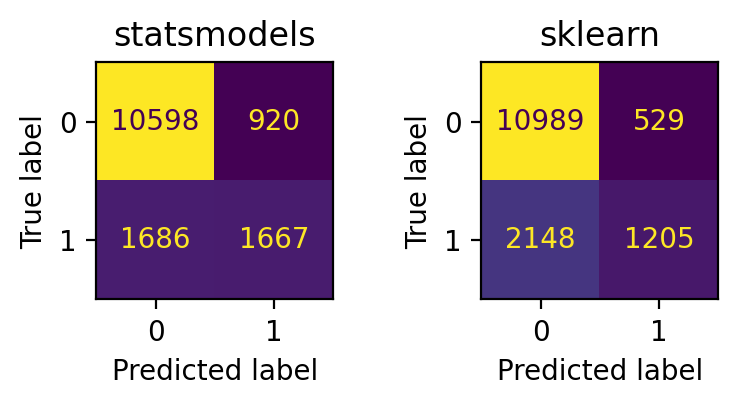

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), dpi=200)
cm_sm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_sm_balanced))
cm_sl = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_sl_balanced))
cm_sm.plot(ax=ax[0], colorbar=False)
ax[0].set_title('statsmodels')
cm_sl.plot(ax=ax[1], colorbar=False)
ax[1].set_title('sklearn')
fig.tight_layout()
plt.show()

Модель из statsmodels чаще верно выявляет класс 1, который для нас является более важным.

## 2. Многоклассовая классификация

Модель многоклассовой классификации также реализована в функции `LogisticRegression` в sklearn. Для многоклассовой классификации в качестве функции потерь внутри используется кросс-энтропия. Также для решения задачи многоклассовой классификации может использоваться модель для бинарной классификации в стратегиях One vs. One (OvO) и One vs. Rest (OvR). Первый вариант обучает модели для решения задачи бинарной классификации между каждой парой уникальных классов. Второй вариант обучает модели бинарной классификации для выделения одного класса из всех остальных.

В качестве примера рассмотрим данные о качестве цемента.

In [23]:
cement = pd.read_csv('data/cement_strength.csv')

In [24]:
cement.head()

,response,V1,V2,V3,V4,V5,V6,V7,V8
0,5,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,5,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [25]:
cement['response'].value_counts()

response
2    310
3    244
1    196
4    152
5     96
Name: count, dtype: int64

In [26]:
X = cement.drop('response', axis=1)
y = cement['response']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Стандартизируем данные и обучим модель многоклассовой логистической регрессии в sklearn.

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
model = LogisticRegression(
    random_state=42,
    solver='lbfgs', # liblinear недоступен для многоклассовой классификации
    class_weight='balanced' # не забудем о том, что выборка не сбалансирована
)

model.fit(X_train_scaled, y_train)
pred_cross_entropy = model.predict(X_test_scaled)

Для стратегий OvO и OvR необходимо воспользоваться специальными оболочками `sklearn.multiclass.OneVsOneClassifier` и `sklearn.multiclass.OneVsRestClassifier`, соответственно.

In [30]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [31]:
model_ovo = OneVsOneClassifier(model)
model_ovo.fit(X_train_scaled, y_train)
pred_ovo = model_ovo.predict(X_test_scaled)

model_ovr = OneVsRestClassifier(model)
model_ovr.fit(X_train_scaled, y_train)
pred_ovr = model_ovr.predict(X_test_scaled)

In [32]:
for model_name, elem in zip(['cross_entropy', 'ovo', 'ovr'], [pred_cross_entropy, pred_ovo, pred_ovr]):
    print('\n', model_name)
    print('accuracy:', accuracy_score(y_test, elem))
    print('precision:', precision_score(y_test, elem, average='macro'))
    print('recall:', recall_score(y_test, elem, average='macro'))
    print('f1_score:', f1_score(y_test, elem, average='macro'))
    print('f2_score:', fbeta_score(y_test, elem, average='macro', beta=2))


 cross_entropy
accuracy: 0.5363636363636364
precision: 0.5201484331317049
recall: 0.5613796939817572
f1_score: 0.5260469816885511
f2_score: 0.5432513390109356

 ovo
accuracy: 0.5696969696969697
precision: 0.5574969720105727
recall: 0.5873132332987469
f1_score: 0.5623046972611994
f2_score: 0.5744143775622575

 ovr
accuracy: 0.5272727272727272
precision: 0.5078304149878
recall: 0.5428343013439589
f1_score: 0.5134076828230533
f2_score: 0.5275298764454062


## 3. Порядковая регрессия

В рассматриваемой задаче значения целевых переменных могут быть упорядочены: $y_i\le y_{i+1}$. Для описания такой целевой переменной может быть построена порядковая регрессия. 

Модель порядковой регрессии можно найти в statsmodels (`statsmodels.miscmodels.ordinal_model.OrderedModel`).

In [33]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [34]:
X = cement.drop('response', axis=1)
y = cement['response']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Создадим вектор априорных вероятностей (частот) классов `y_train.replace(y_train.value_counts(normalize=True))`, сдвигая предсказание модели на величину, зависящую от частоты классов в обучающей выборке.

In [36]:
counts = y_train.value_counts(normalize=True)
train_offset = np.log(y_train.replace(counts).values)

In [37]:
model_ordered = OrderedModel(
    y_train, 
    X_train,
    offset=train_offset,
    distr='logit'
).fit(method='lbfgs')

In [57]:
avg_offset

array([-1.13831216, -1.39230039, -1.64447577, -1.9295772 , -2.37715379])

In [58]:
pred_order

array([4, 1, 2, 4, 2, 2, 1, 2, 3, 1, 1, 2, 3, 1, 1, 4, 3, 5, 1, 2, 2, 4,
       3, 1, 2, 2, 2, 3, 2, 3, 1, 3, 1, 3, 1, 2, 5, 2, 1, 1, 4, 4, 1, 2,
       2, 1, 2, 2, 5, 2, 1, 2, 3, 3, 5, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2,
       3, 2, 2, 3, 5, 5, 1, 2, 2, 2, 3, 1, 3, 2, 5, 2, 2, 2, 2, 2, 1, 1,
       5, 4, 3, 5, 3, 1, 5, 4, 4, 3, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 1, 2,
       3, 5, 5, 2, 3, 3, 2, 3, 4, 2, 2, 2, 5, 2, 3, 3, 5, 3, 3, 3, 2, 3,
       4, 1, 5, 2, 4, 5, 3, 2, 2, 2, 4, 2, 2, 2, 1, 2, 3, 5, 3, 4, 3, 2,
       2, 4, 2, 2, 2, 2, 2, 5, 1, 1, 2, 2, 1, 3, 1, 5, 4, 4, 2, 2, 1, 3,
       2, 3, 2, 5, 2, 5, 2, 4, 1, 2, 2, 3, 1, 2, 1, 3, 3, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 1, 4, 2, 2, 4, 5, 3, 3, 1, 2, 4, 5, 5, 2, 2, 5, 4, 2,
       2, 2, 1, 1, 2, 2, 3, 2, 5, 2, 5, 5, 2, 2, 2, 3, 5, 4, 3, 3, 2, 5,
       5, 4, 4, 3, 4, 2, 1, 4, 2, 3, 2, 4, 5, 4, 4, 2, 2, 1, 4, 4, 2, 5,
       2, 4, 2, 2, 4, 2, 5, 2, 2, 1, 2, 1, 1, 4, 2, 2, 1, 3, 3, 2, 3, 4,
       5, 2, 2, 4, 2, 5, 2, 2, 1, 4, 2, 2, 5, 3, 1,

In [38]:
avg_offset = np.log(counts.values)
constant_offset = np.full(len(X_test), avg_offset[2]) 

pred_order = model_ordered.predict(X_test, offset=constant_offset)

In [39]:
pred_order = pred_order.values.argmax(axis=1) + 1

In [40]:
for model_name, elem in zip(['ovo', 'ordinal'], [pred_ovo, pred_order]):
    print('\n', model_name)
    print('accuracy:', accuracy_score(y_test, elem))
    print('precision:', precision_score(y_test, elem, average='macro'))
    print('recall:', recall_score(y_test, elem, average='macro'))
    print('f1_score:', f1_score(y_test, elem, average='macro'))
    print('f2_score:', fbeta_score(y_test, elem, average='macro', beta=2))


 ovo
accuracy: 0.5696969696969697
precision: 0.5574969720105727
recall: 0.5873132332987469
f1_score: 0.5623046972611994
f2_score: 0.5744143775622575

 ordinal
accuracy: 0.4818181818181818
precision: 0.46557808455565136
recall: 0.4719512295576826
f1_score: 0.4618935225747678
f2_score: 0.46621713424908906


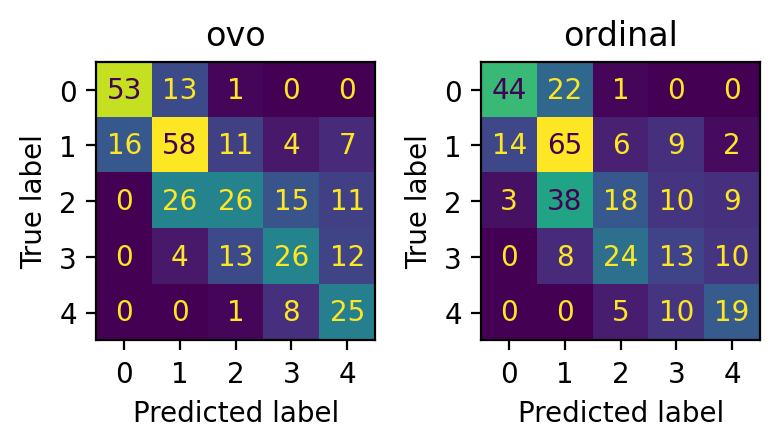

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(4, 3), dpi=200)
cm_sl = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_ovo))
cm_sm = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_order))
cm_sl.plot(ax=ax[0], colorbar=False)
ax[0].set_title('ovo')
cm_sm.plot(ax=ax[1], colorbar=False)
ax[1].set_title('ordinal')
fig.tight_layout()
plt.show()

Ошибки модели порядковой регрессии обычно сосредоточены ближе к главной диагонали.

<div class="alert alert-info">

<h3> Задание (выполнять в отдельном файле)</h3>
<p></p>
Разбейте выборку wine_quality.csv (целевая переменная &ndash; quality) на обучение и контроль. Решите задачу данную задачу следующими способами:
    
<ol>1. Как задачу регрессии (метод LinearRegression из sklearn или GLM из statsmodels). Результат предсказаний на контрольной выборке необходимо округлить до значения класса. Исходная целевая переменная имеет значения [3; 8]. С помощью метода np.clip преобразуйте все значения на нужный интервал.</ol>
    
<ol>2. Как задачу многоклассовой классификации при различных стратегиях (метод LogisticRegression из sklearn, стратегии cross-entropy, ovo, ovr).</ol>
    
<ul>3. Как задачу порядковой регрессии (OrderedModel из statsmodels). </ul>
<p></p>
Сравните качество предсказаний на контрольной выборке.
</div>

In [43]:
data = pd.read_csv('data/wine_quality.csv')

In [44]:
data.head()

,chlorides,sulphates,quality
0,0.076,0.56,5
1,0.098,0.68,5
2,0.092,0.65,5
3,0.075,0.58,6
4,0.076,0.56,5


In [45]:
X = data.drop('quality', axis=1)
y = data['quality']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### 1. Как задачу регрессии (метод LinearRegression из sklearn или GLM из statsmodels). Результат предсказаний на контрольной выборке необходимо округлить до значения класса. Исходная целевая переменная имеет значения [3; 8]. С помощью метода np.clip преобразуйте все значения на нужный интервал.

In [48]:
from sklearn.linear_model import LinearRegression

In [49]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred_linear = model_linear.predict(X_test)
y_pred_linear = np.round(y_pred_linear).astype(int)
y_pred_linear = np.clip(y_pred_linear, 3, 8)

### 2. Как задачу многоклассовой классификации при различных стратегиях (метод LogisticRegression из sklearn, стратегии cross-entropy, ovo, ovr).

In [52]:
model_ce = LogisticRegression(
    random_state=42, 
    solver='lbfgs', 
    class_weight='balanced'
)
model_ce.fit(X_train, y_train)
y_pred_ce = model_ce.predict(X_test)

In [54]:
model = LogisticRegression(
    random_state=42, 
    solver='lbfgs', 
    class_weight='balanced'
)

model_ovo = OneVsOneClassifier(model)
model_ovo.fit(X_train, y_train)
y_pred_ovo = model_ovo.predict(X_test)

model_ovr = OneVsRestClassifier(model)
model_ovr.fit(X_train, y_train)
y_pred_ovr = model_ovr.predict(X_test)

### 3. Как задачу порядковой регрессии (OrderedModel из statsmodels).

In [55]:
counts = y_train.value_counts(normalize=True)
train_offset = np.log(y_train.replace(counts).values)

In [56]:
model_ordered = OrderedModel(
    y_train, 
    X_train,
    offset=train_offset,
    distr='logit'
).fit(method='lbfgs')

In [61]:
avg_offset = np.log(counts.values)
constant_offset = np.full(len(X_test), avg_offset[len(avg_offset)//2])

In [63]:
pred_probs = model_ordered.predict(X_test, offset=constant_offset)

In [64]:
y_pred_ord = pred_probs.values.argmax(axis=1) + y_train.min()

### Сравните качество предсказаний на контрольной выборке

In [74]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
print('Regression')
print('accuracy:', accuracy_score(y_test, y_pred_linear))
print('precision:', precision_score(y_test, y_pred_linear, average='macro'))
print('recall:', recall_score(y_test, y_pred_linear, average='macro'))
print('f1_score:', f1_score(y_test, y_pred_linear, average='macro'))
print('f2_score:', fbeta_score(y_test, y_pred_linear, average='macro', beta=2))

Regression
accuracy: 0.5037878787878788
precision: 0.236
recall: 0.20838038986607818
f1_score: 0.18688191561944478
f2_score: 0.19602982464028582


In [76]:
for model_name, elem in zip(['cross_entropy', 'ovo', 'ovr'], 
                            [y_pred_ce, y_pred_ovo, y_pred_ovr]):
    print('\n', model_name)
    print('accuracy:', accuracy_score(y_test, elem))
    print('precision:', precision_score(y_test, elem, average='macro'))
    print('recall:', recall_score(y_test, elem, average='macro'))
    print('f1_score:', f1_score(y_test, elem, average='macro'))
    print('f2_score:', fbeta_score(y_test, elem, average='macro', beta=2))


 cross_entropy
accuracy: 0.13446969696969696
precision: 0.1718093208411977
recall: 0.28138527448410516
f1_score: 0.10891988085900399
f2_score: 0.11333055360431642

 ovo
accuracy: 0.20833333333333334
precision: 0.21798209754097184
recall: 0.27037193923776576
f1_score: 0.1498677851299837
f2_score: 0.14568457780119662

 ovr
accuracy: 0.3390151515151515
precision: 0.23424126889823624
recall: 0.3034969105331859
f1_score: 0.19315472301130934
f2_score: 0.20711957476616535


In [77]:
print('\n', 'ordinal')
print('accuracy:', accuracy_score(y_test, y_pred_ord))
print('precision:', precision_score(y_test, y_pred_ord, average='macro'))
print('recall:', recall_score(y_test, y_pred_ord, average='macro'))
print('f1_score:', f1_score(y_test, y_pred_ord, average='macro'))
print('f2_score:', fbeta_score(y_test, y_pred_ord, average='macro', beta=2))


 ordinal
accuracy: 0.3958333333333333
precision: 0.06816699282452707
recall: 0.16052227342549924
f1_score: 0.09569597069597069
f2_score: 0.12629925066473288
